In [ ]:
#dataset link: https://archive.ics.uci.edu/dataset/222/bank+marketing
data = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'

In [ ]:
#download the data and save it as telco_data.csv
!wget $data -O data/bank_marketing.zip 

--2024-10-13 11:42:36--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data/bank_marketing.zip’

data/bank_marketing     [           <=>      ] 999.85K   307KB/s    in 3.3s    

2024-10-13 11:42:41 (307 KB/s) - ‘data/bank_marketing.zip’ saved [1023843]



In [ ]:
!unzip data/bank_marketing.zip -d data/

Archive:  data/bank_marketing.zip
 extracting: data/bank.zip           
 extracting: data/bank-additional.zip  


In [ ]:
!unzip data/bank.zip -d data/

Archive:  data/bank.zip
  inflating: data/bank-full.csv      
  inflating: data/bank-names.txt     
  inflating: data/bank.csv           


##### Input variables:
**bank client data:**
1. age (numeric)
2. job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
3. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
4. education (categorical: "unknown","secondary","primary","tertiary")
5. default: has credit in default? (binary: "yes","no")
6. balance: average yearly balance, in euros (numeric) 
7. housing: has housing loan? (binary: "yes","no")
8. loan: has personal loan? (binary: "yes","no")

**related with the last contact of the current campaign:**
1. contact: contact communication type (categorical: "unknown","telephone","cellular") 
2. day: last contact day of the month (numeric)
3. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
4. duration: last contact duration, in seconds (numeric)  
    **Important note:** this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the **duration is not known before a call** is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

**other attributes:**
1. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
2. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
3. previous: number of contacts performed before this campaign and for this client (numeric)
4. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

##### Output variable (desired target)
y - has the client subscribed a term deposit? (binary: "yes","no")

## Importing Libraries

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

## Loading the dataset

In [4]:
df=pd.read_csv('./data/bank-full.csv',delimiter=';') 
print(df.shape)
df.head()

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [6]:
needed_columns=['age','job','marital','education','balance','housing','contact','day','month','duration','campaign','pdays','previous','poutcome','y']
df_mod=df[needed_columns].copy()
df_mod

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,825,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,1729,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,5715,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,668,no,telephone,17,nov,508,4,-1,0,unknown,no


In [7]:
#target encoding
df_mod.y=(df_mod.y=='yes').astype(int)
df_mod.y

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45211, dtype: int64

#### Split the data

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# we want train_size=60%, validation_size=20%, test_size=20%
df_full_train, df_test = train_test_split(df_mod, test_size=0.2, random_state=1)        
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

#reseting the index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

#separating the target value from features
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

## Questions and Answers

### Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
* Use the training dataset for that
* If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is **negatively correlated** with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?
* balance
* day
* duration
* previous

In [7]:
df_train.dtypes

age           int64
job          object
marital      object
education    object
balance       int64
housing      object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
dtype: object

In [11]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
from sklearn.metrics import roc_auc_score

numeric_cols=['age','balance','day','duration','campaign','pdays','previous']
auc_score_dict=dict()

for col in numeric_cols:
    auc_score=roc_auc_score(y_train, df_train[col])
    if auc_score<0.5:   #incase  of negatively correlated variable
        auc_score=roc_auc_score(y_train, -df_train[col])

    auc_score_dict[col]=auc_score

In [19]:
auc_score_dict

{'age': np.float64(0.512185717527344),
 'balance': np.float64(0.5888313805382317),
 'day': np.float64(0.525957882383908),
 'duration': np.float64(0.8147002759670778),
 'campaign': np.float64(0.5714543015682159),
 'pdays': np.float64(0.5901276247352144),
 'previous': np.float64(0.5985653242764153)}

Answer: duration

### Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:  
`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

What's the AUC of this model on the validation dataset? (round to 3 digits)
* 0.69
* 0.79
* 0.89
* 0.99


In [27]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv=DictVectorizer(sparse=False)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [28]:
#converting the data frame to a dictionary
train_dict=df_train.to_dict(orient='records')
print(train_dict[:1])


#OHE the categorical values and prepare a numpy array
X_train=dv.fit_transform(train_dict)
print(list(X_train[0]))



#converting the data frame to a dictionary
val_dict=df_val.to_dict(orient='records')
print(val_dict[:1])

#OHE the categorical values and prepare a numpy array
X_val=dv.transform(val_dict)
print(list(X_val[0]))

[{'age': 56, 'job': 'entrepreneur', 'marital': 'married', 'education': 'tertiary', 'balance': 40, 'housing': 'no', 'contact': 'cellular', 'day': 11, 'month': 'jul', 'duration': 123, 'campaign': 2, 'pdays': -1, 'previous': 0, 'poutcome': 'unknown'}]
[np.float64(56.0), np.float64(40.0), np.float64(2.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(11.0), np.float64(123.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-1.0), np.float64(0.0), np.float64(0.

In [32]:
#fitting the model
model.fit(X_train,y_train)

#get prediction on validation dataset
y_pred=model.predict_proba(X_val)[:,1]

#getting the AUC score
auc_score=roc_auc_score(y_val, y_pred)
round(auc_score,3)

np.float64(0.9)

Answer: 0.89

### Question 3: Precision and Recall
Now let's compute precision and recall for our model.
* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?
* 0.265
* 0.465
* 0.665
* 0.865


In [35]:
print(y_val[:10])
print(y_pred[:10])

[0 0 0 0 0 0 0 0 0 0]
[0.0299613  0.02312939 0.02077408 0.01519179 0.02680079 0.03861708
 0.05382997 0.03309846 0.06058269 0.00666836]


In [37]:
#getting precision and recall for threshold=0.5
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t=0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

p = tp / (tp + fp)   #TP/Predicted Positive
r = tp / (tp + fn)   #TP/Actual (Real) Positive
p,r

(np.float64(0.6601769911504425), np.float64(0.33970856102003644))

In [39]:
#getting precision and recall for different threshold
scores = []

thresholds = np.linspace(0, 1, 101)   #thresholds from 0.0 to 1.0 with step 0.01

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)  #TP/Predicted Positive
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)        #TP/Actual (Real) Positive

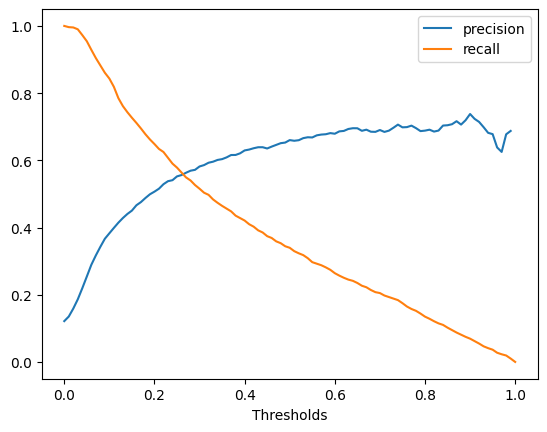

In [45]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.xlabel('Thresholds')
plt.legend()

Answer: 0.265

### Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:  
`F1=(2.P.R)/(P+R)`  
Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?
* 0.02
* 0.22
* 0.42
* 0.62

In [42]:
print(df_scores.shape)
df_scores.head()

(101, 7)


,threshold,tp,fp,fn,tn,precision,recall
0,0.00,1098,7944,0,0,0.121433,1.000000
1,0.01,1094,7004,4,940,0.135095,0.996357
2,0.02,1093,5789,5,2155,0.158820,0.995446
3,0.03,1087,4745,11,3199,0.186385,0.989982
4,0.04,1068,3800,30,4144,0.219392,0.972678


In [44]:
#getting f1 score
df_scores['f1_score']=(2 * df_scores.precision * df_scores.recall)/(df_scores.precision + df_scores.recall)
df_scores.sort_values(by='f1_score',ascending=False).head()

,threshold,tp,fp,fn,tn,precision,recall,f1_score
22,0.22,686,611,412,7333,0.528913,0.624772,0.572860
23,0.23,667,573,431,7371,0.537903,0.607468,0.570573
19,0.19,727,730,371,7214,0.498970,0.662113,0.569080
20,0.20,712,693,386,7251,0.506762,0.648452,0.568917
21,0.21,696,654,402,7290,0.515556,0.633880,0.568627


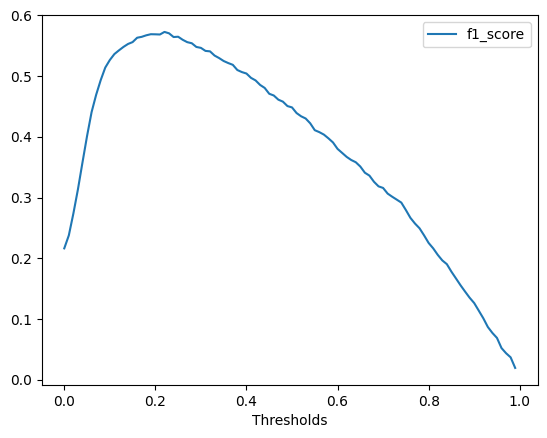

In [46]:
plt.plot(df_scores.threshold, df_scores['f1_score'], label='f1_score')
plt.xlabel('Thresholds')
plt.legend()

Answer: 0.22

### Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:  
`KFold(n_splits=5, shuffle=True, random_state=1)`
* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?
* 0.0001
* 0.006
* 0.06
* 0.26


In [16]:
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
import warnings
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

warnings. filterwarnings('ignore')

In [17]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')       #getting dataframe as dictionary

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)                                       #OHE

    model = LogisticRegression(solver='liblinear',C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model


def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [18]:
#cross validation
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):   
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values


    del df_train['y']
    del df_val['y']

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.906 +- 0.006


Answer: 0.006

### Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter `C`
* Iterate over the following C values: `[0.000001, 0.001, 1]`
* Initialize KFold with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?
* 0.000001
* 0.001
* 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [19]:
#parameter tuning
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):   
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values


        del df_train['y']
        del df_val['y']

        dv, model = train(df_train, y_train, C=1.0)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 33%|███▎      | 1/3 [00:04<00:08,  4.02s/it]

C=1e-06 0.906 +- 0.006


 67%|██████▋   | 2/3 [00:10<00:05,  5.59s/it]

C=0.001 0.906 +- 0.006


100%|██████████| 3/3 [00:17<00:00,  5.69s/it]

C=1 0.906 +- 0.006


Answer: 0.000001